### Numerically solving the dynamic differential equations of a protein production system. 

#### The equations are from the paper [Global signatures of protein and mRNA expression levels ](https://www.ncbi.nlm.nih.gov/labs/pmc/articles/PMC4089977/).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.integrate import solve_ivp


sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)

#### The first order differential equation describing the system is:
$$\frac{dP}{dt} = k_{ProteinProduction} - k_{ProteinDegradation}\times P$$

where, 
$$ k_{ProteinProduction} = k_{Translation}\times R $$

In [2]:
def dy_dx(time, protein, k_translation, k_degradation, mRNA):
    return k_translation*mRNA - k_degradation*protein

#### From the paper, $k_{ProteinDegradation}$ and $R$ are constants. 

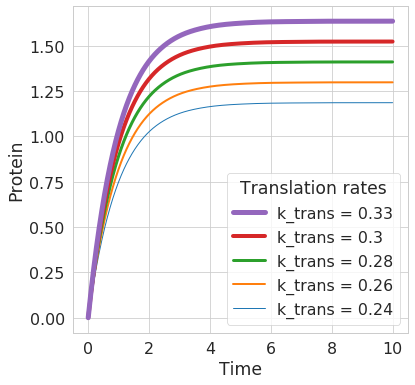

In [3]:
rnd = np.random.default_rng(12345)

N = 5
k_degradation = 1
k_translation = np.linspace(0.01, 0.1, N) + rnd.uniform()
mRNA = 5 # (R in the paper)
T = 10


## Inital conditions
times = np.linspace(0, 10, 1000)
proteins0 = 0.0  # protein at time=0

solutions = []
protein_produced = []

plt.figure(figsize=(6, 6))


for a in range(N):
    solution = solve_ivp(dy_dx, [0, T], [proteins0, ], \
                         args=(k_translation[a], k_degradation, mRNA), t_eval=times)
    solutions.append(solution)
    protein_produced.append(solution.y.flatten())
    
    ax = sns.lineplot(x=times, y=protein_produced[a], label='k_trans = {}'.\
                      format(np.round(k_translation[a], 2)),\
                 lw=[1, 2, 3, 4, 5][a])
    ax.set_xlabel('Time')
    ax.set_ylabel('Protein');
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Translation rates', loc='lower right');
plt.savefig('figs/protein_vs_translation_rates.png', bbox_inches='tight', pad_inches=0)

#### We can simulate the system with many mRNAs with their own concentration and degradation constants

In [4]:

N = 100 # Number of timepoints
P = 1000 # Number of different proteins
times = np.linspace(0, 10, N)
T = 10


rnd = np.random.default_rng(12345)
mRNAs = rnd.uniform(10, 100, P)
k_degradations = rnd.uniform(0.01, 1, P)
k_translations = np.arange(0.1, 1.1, 0.1)




In [5]:
def rate_analysis(mRNA, k_translation, k_deg, rnd):
    times = np.linspace(0, 10, 100)
    proteins0 = 0.0  # protein at time=0

    all_proteins = [] # proteins for different translation rates

    for a, b in enumerate(k_translation):
        k_trans = b * rnd.uniform()
        solution = solve_ivp(dy_dx, [0, T], [proteins0, ], \
                         args=(k_trans, k_deg, mRNA), t_eval=times)
        proteins = solution.y.flatten()
        all_proteins.append(proteins)
    return np.array(all_proteins)

In [6]:
different_experiments = [rate_analysis(v, k_translations, k_degradations[i], rnd) for i, v in enumerate(mRNAs)]

### Plotting results from simulated experiment and the correlation between mRNA and protein.

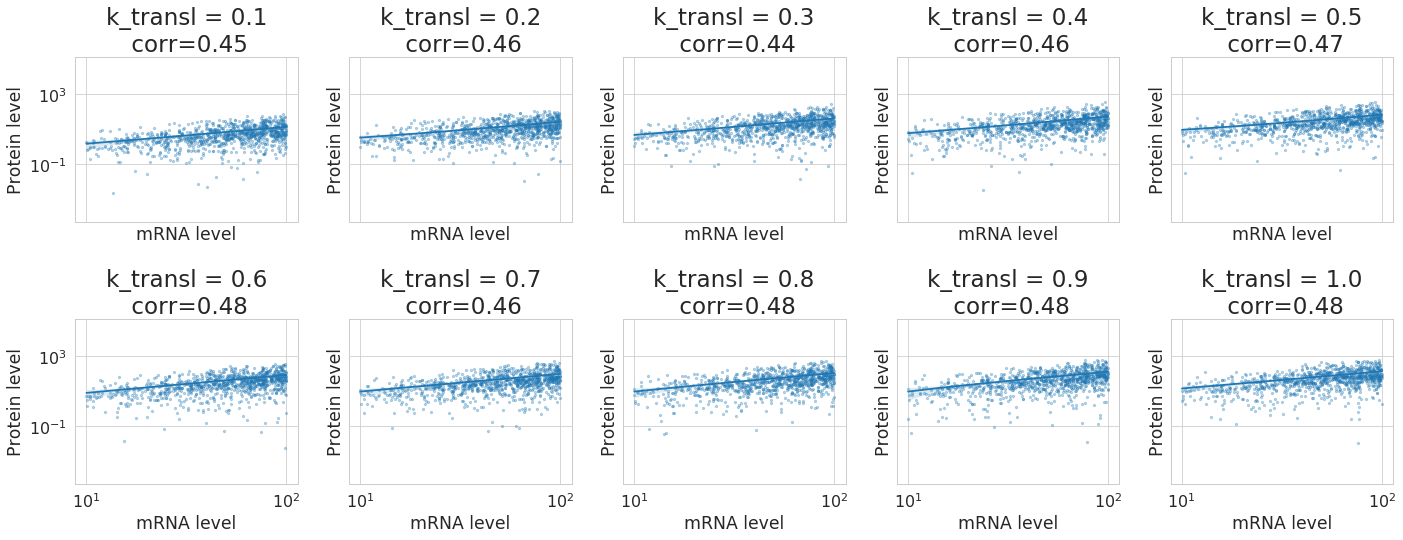

In [7]:
# Plot
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharex=True, sharey=True)
axes = axs.flatten()
corrs = []

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.4)


for r in range(10): #because we have 10 different translation rates   

    endpoint_proteins = [i[:, -1][r] for i in different_experiments]
    endpoint_mRNAs = mRNAs # because mRNA is assumed to be a constant
    ax = sns.regplot(x=endpoint_mRNAs, y=endpoint_proteins, ax=axes[r], \
                    scatter_kws={'s':5, 'alpha':0.3})

    ax.set_xlabel('mRNA level')
    ax.set_xscale('log')
    ax.set_ylabel('Protein level')
    ax.set_yscale('log');

    corrs.append(spearmanr(endpoint_mRNAs, endpoint_proteins))
    ax.set_title('k_transl = {}\n corr={}'.format(np.round(k_translations[r], 2), \
                                                 np.round(corrs[r][0], 2)))

plt.tight_layout()
plt.savefig('figs/protein_vs_translation_rates_for_different_mRNA.png', bbox_inches='tight', pad_inches=0)

#### Plotting steady state mRNA for different proteins at different mRNA concentration and translation rates

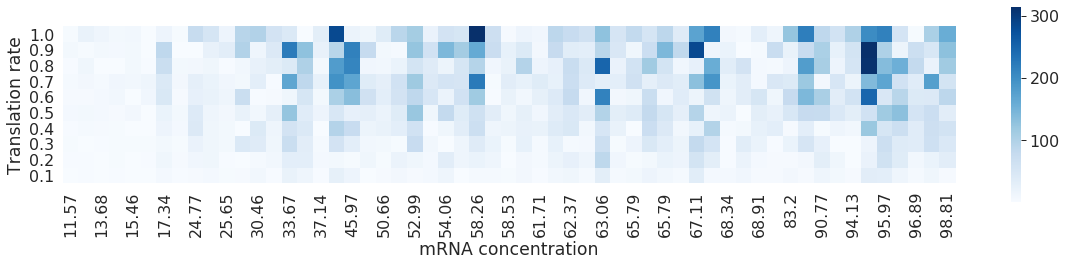

In [8]:
all_endpoints = pd.DataFrame(np.array(different_experiments)[:, :, -1],).transpose() 
all_endpoints.columns = np.round(mRNAs, 2)
all_endpoints.index = np.round(k_translations, 2)


plt.figure(figsize=(20, 4))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)

ax = sns.heatmap(all_endpoints[np.sort(np.round(mRNAs, 2)[np.arange(0, 1000, 20)])], cmap='Blues', \
                square=True, cbar_kws={"shrink": .9})
ax.set_xlabel('mRNA concentration')
ax.set_ylabel('Translation rate')
ax.invert_yaxis();
# plt.savefig('figs/heatmap_translation_rates_vs_mRNA.pdf',  bbox_inches='tight', pad_inches=0)
plt.savefig('figs/protein_vs_translation_rates_vs_mRNA_steady_state.png', bbox_inches='tight', pad_inches=0)

#### So far, we assumed mRNA to be a constant. We can also model the transcription and decay of mRNA. 
The equation for decaying mRNA is from [The role of mRNA and protein stability in gene expression ](https://pubmed.ncbi.nlm.nih.gov/2676679).

$$\frac{dR}{dt} = k_{Transcription} - k_{mRNADegradation}\times R$$

We still have the equation for protein expression.

$$\frac{dP}{dt} = k_{ProteinProduction} - k_{ProteinDegradation}\times P$$

where, 
$$ k_{ProteinProduction} = k_{Translation}\times R $$

We now have a system of coupled first order differential equations.

In [9]:
def dy_dx_1(time, y, k_translation, k_degradation, k_transcription, k_mrnadegradation):
    mRNA, protein = y
    return [k_transcription - k_mrnadegradation*mRNA, k_translation*mRNA - k_degradation*protein]

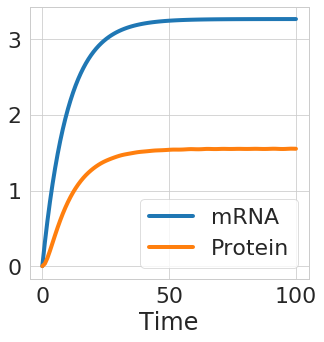

In [10]:
rnd = np.random.default_rng(12345)

N = 5
k_degradation = 0.5
k_mrnadegradation = 0.1
k_translation = np.linspace(0.01, 0.1, N) + rnd.uniform()
k_transcription = np.linspace(0.01, 0.1, N) + rnd.uniform()
mRNA = 0

T = 100
proteins0 = 0.0  # protein at time=0

res = solve_ivp(dy_dx_1, [0., T], [mRNA, proteins0], args=(k_translation[0],\
                                   k_degradation, k_transcription[0], k_mrnadegradation), \
               dense_output=True, t_eval=np.linspace(0, T, 100))


plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.5)
sns.lineplot(x=res.t, y=res.y[0], label='mRNA', lw=4)
ax = sns.lineplot(x=res.t, y=res.y[1], label='Protein', lw=4)
ax.set_xlabel('Time');
plt.savefig('figs/decaying_mRNA_and_protein.png', bbox_inches='tight', pad_inches=0)

In [14]:
# Repeating this for different parameters

def rate_analysis_1(mRNA, k_translation, k_degradation, k_transcription, k_mrnadegradation, rnd, T=20):

    proteins0 = 0.0

    all_proteins = [] # proteins for different translation rates
    all_mrnas = []
    max_prot = []
    max_mrns = []

    for a, b in enumerate(k_translation):
        k_translation = b * rnd.uniform()
        res = solve_ivp(dy_dx_1, [0., T], [mRNA, proteins0], args=(k_translation,\
                                            k_degradation, k_transcription, k_mrnadegradation), \
               dense_output=True, t_eval=np.linspace(0, T, 100))
        mrns, proteins = res.y[0].flatten(), res.y[1].flatten()
        steady_protein = np.max(proteins)
        steady_protein_rna = mrns[np.where(proteins == steady_protein)]
        max_prot.append(steady_protein)
        max_mrns.append(steady_protein_rna)
        all_proteins.append(proteins)
        all_mrnas.append(mrns)
    return np.array(all_proteins), np.array(all_mrnas), np.array(max_prot), np.array(max_mrns)

In [20]:

P = 1000 # Number of different proteins
T = 20


rnd = np.random.default_rng(12345)
mRNAs = np.zeros(P)
k_degradations = rnd.uniform(0.01, 1, P)
k_mrnadegradations = rnd.uniform(0.01, 1, P)
k_translations = np.arange(0.1, 1.1, 0.1)
k_transcriptions = np.linspace(0.01, 0.1, P) + rnd.uniform()

different_experiments_1 = [rate_analysis_1(v, k_translations, k_degradations[i],  \
                                       k_transcriptions[i], k_mrnadegradations[i], \
                                       rnd, T) for i, v in enumerate(mRNAs)]

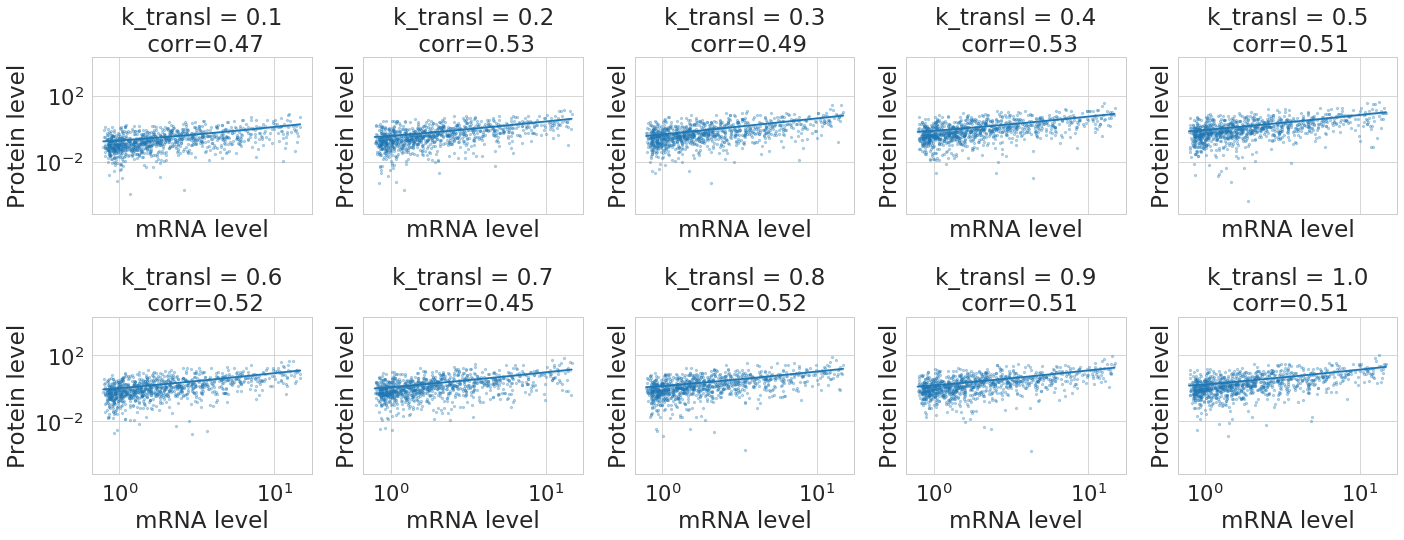

In [23]:
# Plot
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharex=True, sharey=True)
axes = axs.flatten()
corrs = []

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.4)


for r in range(10): #because we have 10 different translation rates   

    endpoint_proteins = np.array([i[2][r] for i in different_experiments_1]).flatten()
    endpoint_mRNAs = np.array([i[3][r] for i in different_experiments_1]).flatten()
    ax = sns.regplot(x=endpoint_mRNAs, y=endpoint_proteins, ax=axes[r], \
                    scatter_kws={'s':5, 'alpha':0.3})

    ax.set_xlabel('mRNA level')
    ax.set_xscale('log')
    ax.set_ylabel('Protein level')
    ax.set_yscale('log');

    corrs.append(spearmanr(endpoint_mRNAs, endpoint_proteins))
    ax.set_title('k_transl = {}\n corr={}'.format(np.round(k_translations[r], 2), \
                                                 np.round(corrs[r][0], 2)))

plt.tight_layout()
plt.savefig('figs/mRNA_and_protein_with_decay.png', bbox_inches='tight', pad_inches=0)